#### Justify choice of architecture based on exploratory analysis

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# path = 'data/'
path = '/content/drive/My Drive/M5_Competition/data/'

calendar = pd.read_csv(path+'calendar.csv')
sales_train = pd.read_csv(path+'sales_train_validation.csv')
sales = sales_train.iloc[:, :6]
# sample = pd.read_csv(path+'sample_submission.csv')
# sell_prices = pd.read_csv(path+'sell_prices.csv')

#### Graph of dependencies
In our work we considered that on the market there are a lot of complementary goods. This means that the consumption of one product may influence the consumption of another one. Both positively and negatively. In correspondence with the [article](https://arxiv.org/pdf/1809.09441.pdf) we state a hypothesis that the prediction of sales might be improved by the use of graph of dependencies between various products. These dependencies are measured by affiliation of any product to one another group. The groups are composed due to the hierarchical structure proposed in M5 Competition Guideline. We came to conclusion that the best set of IDs which are used to group the products is $\text{['state_id', 'store_id', 'cat_id', 'dept_id']}$. Such grouping divides the initial dataset of historical sales into 70 groups. 

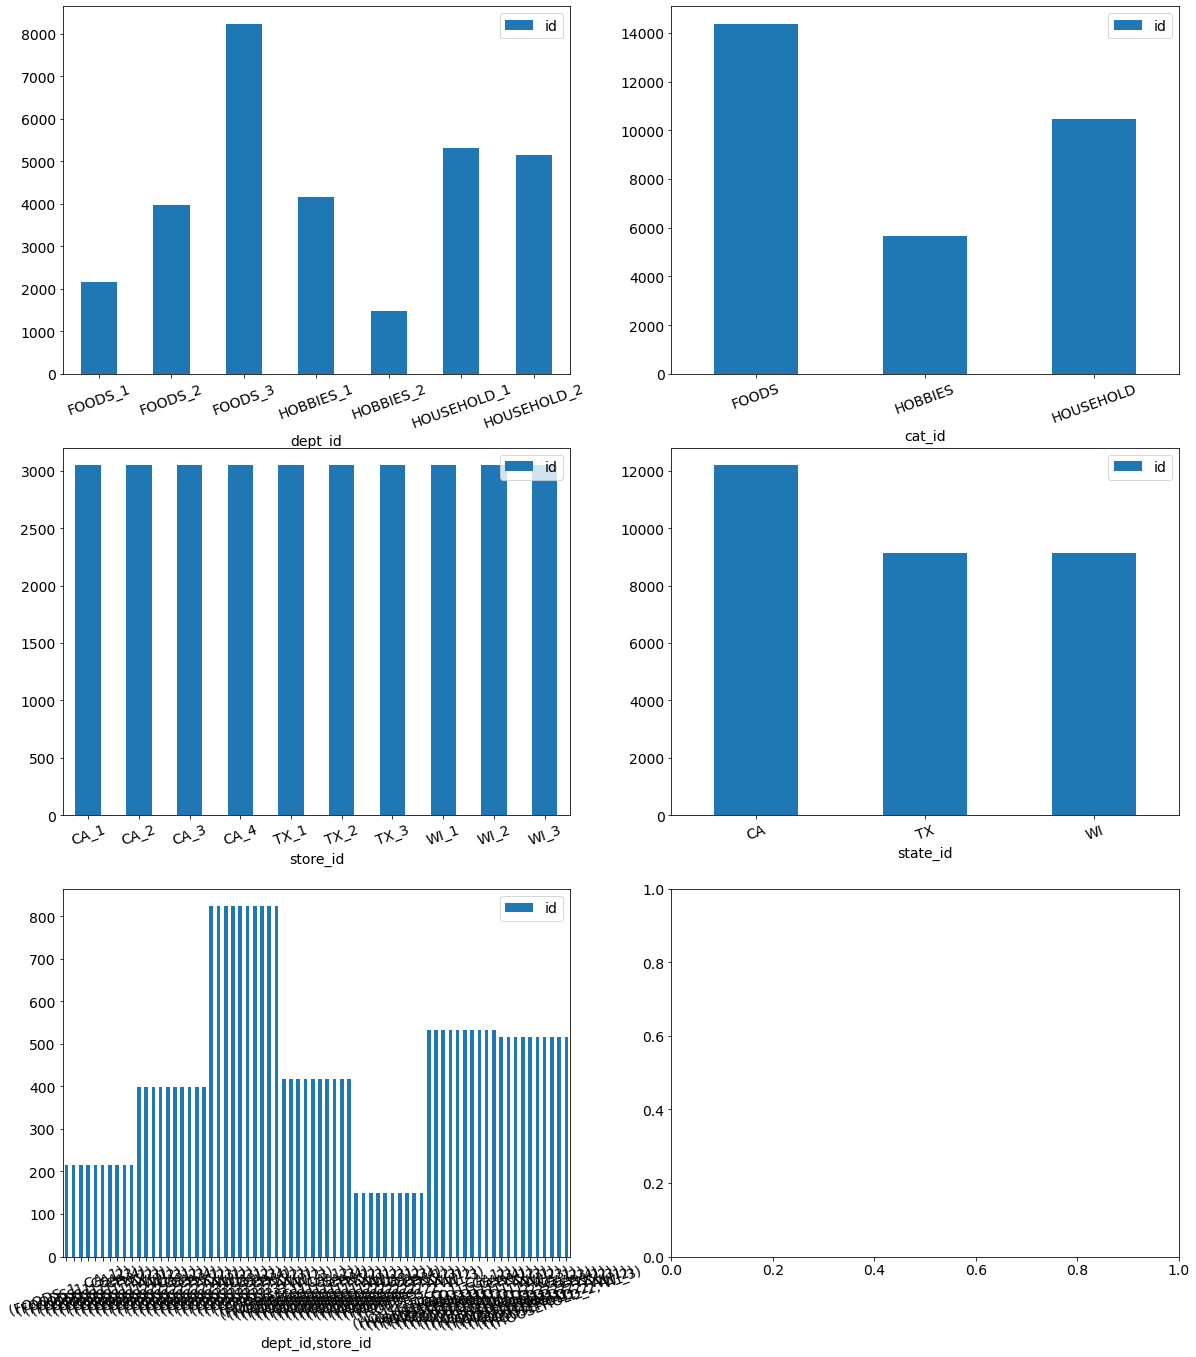

In [6]:
from itertools import product

def plot_cat(categories=sales.columns[2:]):
    cat_num, add = len(categories) // 2, len(categories) % 2
    range_ = range(cat_num+add)
    plt.rcParams.update({'font.size':14})
    f, axes = plt.subplots(cat_num + add, 2, figsize=(20, 23))
    
    for (row, col), cat in zip(list(product(range_, [0, 1])), categories):
        sales.groupby(by=cat).count().iloc[:, :1].plot(kind='bar', ax=axes[row, col], rot=20, )

cats = ['dept_id', 'cat_id', 'store_id', 'state_id', ['dept_id', 'cat_id', 'store_id', 'state_id']]
cats = ['dept_id', 'cat_id', 'store_id', 'state_id', ['dept_id','store_id']]

plot_cat(cats)

#### Pearson correlation coefficient 
In order to ensure the beneficial influence of the described method of grouping onto the forecasting performance we calculate Pearson correlation coefficient (pairwise averaged) for both grouped and random sets of products. Before taking the average we leave out the sign of the correlation taking into account only the absolute value of the coefficient in order to eliminate situations when the there are correlations of both signs which eliminate each other when averaging.

In [7]:
np.random.seed(seed=1)

cats = ['state_id', 'store_id', 'cat_id', 'dept_id']
sales_ind = sales.reset_index()
groups_lst = sales_ind.groupby(cats)['index'].apply(list).values

pearson_grouped = []
pearson_rand = []
for indices in tqdm(groups_lst.flatten()):
    length = len(indices)
    
    # grouped pearson corr coef calc
    df = sales_train.iloc[indices, 6:].T
    pearson_grouped.append(np.abs(df.corr()).mean().mean())
    
    # random pearson corr coef calc
    indices_rand = np.random.randint(len(sales), size=length)
    df_rand = sales_train.iloc[indices_rand, 6:].T
    pearson_rand.append(np.abs(df_rand.corr()).mean().mean())

print(f"Grouped Pearson: {np.mean(pearson_grouped)}")
print(f"Random Pearson: {np.mean(pearson_rand)}")


Grouped Pearson: 0.06207252268073788
Random Pearson: 0.05786762787996122


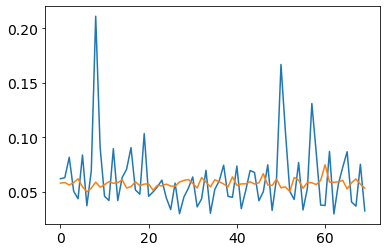

In [14]:
# print(pearson_grouped)
# print(pearson_rand)

plt.plot(pearson_grouped)
plt.plot(pearson_rand)
plt.show()

#### Conclusion:
We conclude that grouping might improve forecasting performance indeed as Pearson coefficient for products in one group is higher than for random products.

Inspired by the idea that two companies in the same sector or industry may exhibit similar trends in their stock prices from [Temporal Relational Ranking for Stock Prediction](https://arxiv.org/pdf/1809.09441.pdf) we show that products in the same group may also be of similar shape and trend

In [22]:
! pip install statsmodels --upgrade

     |████████████████████████████████| 8.7MB 3.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


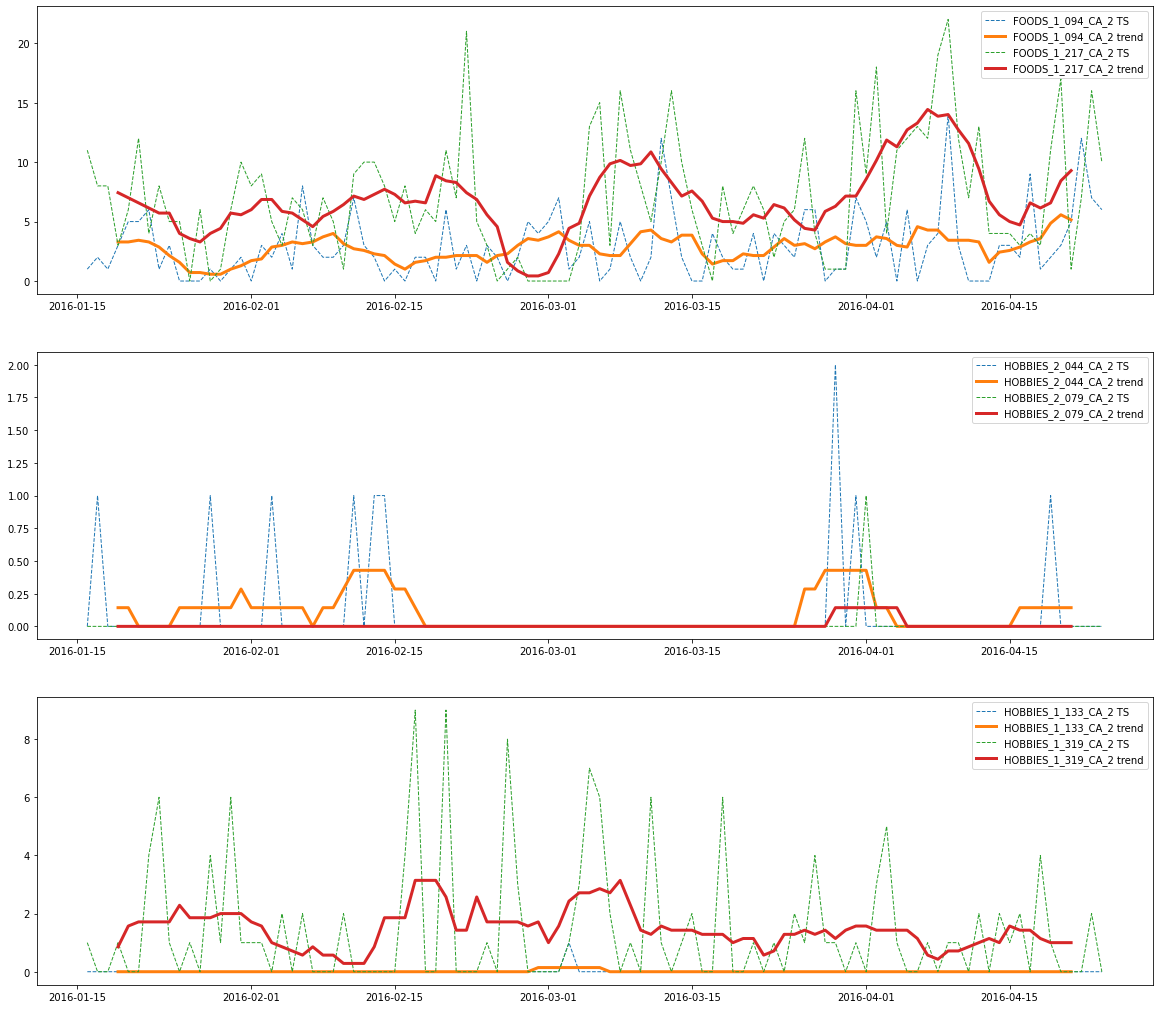

In [37]:
import statsmodels.api as sm

import random
random.seed(2)


def plot(num_1=2, num_2=3, days_back=100, cats=['state_id', 'store_id', 'cat_id', 'dept_id']):
    fig, axes = plt.subplots(num_2, 1, figsize=(20, 18))
    
    sales_ind = sales.reset_index()
    groups_lst = sales_ind.groupby(cats)['index'].apply(list).values
    groups_lst = list(groups_lst.flatten())

    for i, group in enumerate(random.sample(groups_lst, num_2)):
        for ind in random.sample(group, num_1):
            id_ = sales.loc[sales.index[ind], 'id'] 
            name = id_[:-id_[::-1].find('_')-1]

            ts = sales_train.iloc[ind, -days_back:]
            ts.index = calendar.loc[calendar.d.isin(ts.index.values), 'date'].values
            ts.index = pd.to_datetime(ts.index)
            
#             slope = np.polyfit(list(range(len(ts.index.values))), ts.values, deg=1)[-2]
#             print(slope)
            
            decomp = sm.tsa.seasonal_decompose(ts, model='additive')
            
            axes[i].plot(ts, linestyle='dashed', linewidth=1, label=f'{name} TS')
            axes[i].plot(decomp.trend, linewidth=3, label=f'{name} trend')
            axes[i].legend()
            axes[i].grid()

plot()

#### Combined Sales over time by type

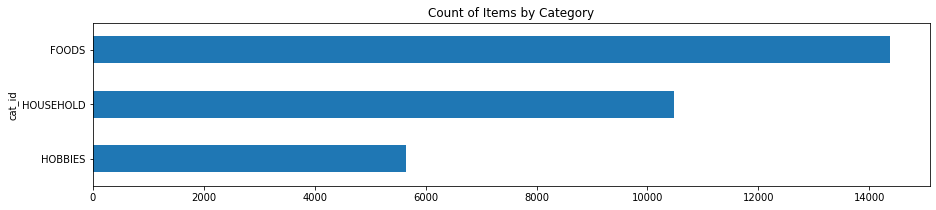

In [0]:
df_temp = sales.groupby('cat_id').count()['id'].sort_values()
df_temp.plot(kind='barh', figsize=(15, 3), title='Count of Items by Category')

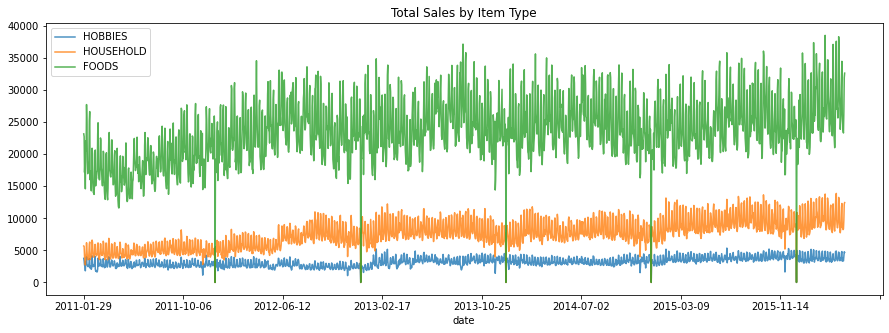

In [0]:
d_cols = [c for c in sales_train.columns if 'd_' in c] # sales data columns
past_sales = sales_train.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'],
                                                       left_index=True,
                                                       right_index=True,
                                                       validate='1:1').set_index('date')
past_sales

for i in sales_train['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5),
                                           alpha=0.8,
                                           title='Total Sales by Item Type')
plt.legend(sales['cat_id'].unique())
plt.show()